In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns
from tqdm import tqdm

/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2]:
%matplotlib inline

/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
metrics = context.catalog.load('metrics_history')

2020-12-03 15:40:07,287 - kedro.io.data_catalog - INFO - Loading data from `metrics_history` (PickleDataSet)...


In [4]:
metrics['epochs']

4

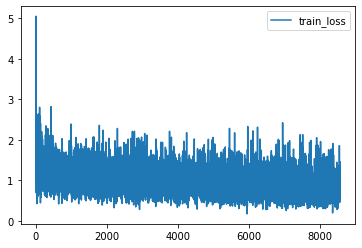

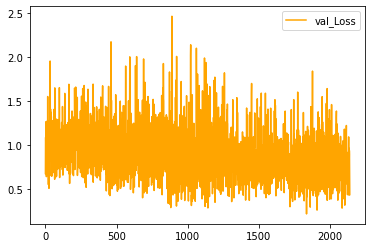

In [5]:
plt.figure()
sns.lineplot(data=metrics['train_losses'], label='train_loss')
plt.show()

plt.figure()
sns.lineplot(data=metrics['validation_losses'], label='val_Loss', color='orange')
plt.show()

In [6]:
model = context.catalog.load('model')

2020-12-03 15:40:08,128 - kedro.io.data_catalog - INFO - Loading data from `model` (TorchLocalModel)...


/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Using cache found in /home/boris/.cache/torch/hub/pytorch_vision_v0.6.0


In [74]:
model.eval()

ResnetModel(
  (trunk): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [75]:
def plot_image(img, label=None, ax=None):
    if not ax:
        ax = plt.gca()
    ax.imshow(img.permute(1, 2, 0))
    ax.axis('off')
    if label is not None:
        
        if isinstance(label, int):
            label = label_num_to_disease_map.get(label, 0)
        ax.set_title(f'L: {label}')

In [76]:
train_images_torch = context.catalog.load('train_images_torch')

2020-12-03 15:48:39,185 - kedro.io.data_catalog - INFO - Loading data from `train_images_torch` (ImageFolderDataSet)...


In [77]:
from torchvision import transforms

In [78]:
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(227),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

train_images_torch.transform = val_transform

In [79]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

unnorm = UnNormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Predict on random image

In [83]:
probabilities.detach().numpy()

array([5.8991747e-04, 1.0184825e-02, 2.9345669e-03, 9.8421150e-01,
       2.0792116e-03], dtype=float32)

/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/boris/Documents/kaggle cassava/cassava/src/cassava/models/resnet50.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


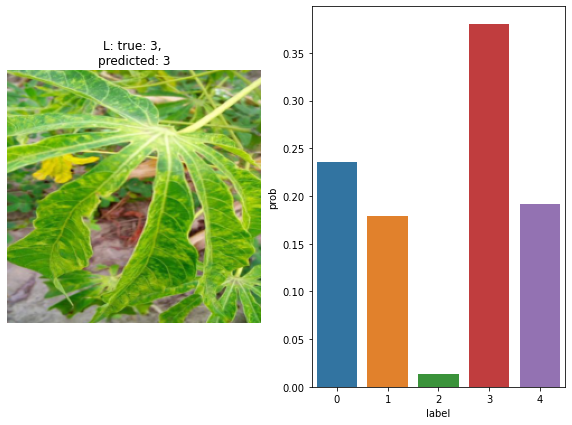

In [152]:
random_idx = np.random.choice(range(len(train_images_torch)))
image, label = train_images_torch[random_idx]

probabilities = model.predict(image.unsqueeze(0))[0]
prediction = model.predict_label(image.unsqueeze(0)).item()

plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
plot_image(unnorm(image), label=f"true: {label}, \npredicted: {prediction}")
plt.subplot(1, 2, 2)
sns.barplot(y=probabilities.detach().numpy(), x=list(range(5)))
plt.xlabel('label')
plt.ylabel('prob')
plt.show()